In [322]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import hashlib

In [427]:
def check_img_bounds(x, y, w, h, img_x, img_y, slice_size):
    """
    Checks if a newly created box is within the boundaries of the image.
    Adjusts the box if the box is outside the boundaries of the image.
    """
    if x < 0:
        x = 0
        w = x + slice_size[0]
    if y < 0:
        y = 0
        h = y + slice_size[1]
    if w > img_x:
        x = img_x - slice_size[0]
        w = img_x
    if h > img_y:
        y = img_y - slice_size[1]
        h = img_y
    return x, y, w, h   

def create_box(row_label, img_x, img_y, slice_size):
    """
    Creates a box to slice over a label.
    """
    x_cen = (row_label["w"] - (row_label["w"] - row_label["x"])/2) 
    y_cen = (row_label["h"] - (row_label["h"] - row_label["y"])/2) 
    
    x = x_cen - (slice_size[0]/2)
    y = y_cen - (slice_size[1]/2)
    w = x_cen + (slice_size[0]/2)
    h = y_cen + (slice_size[1]/2)
    
    x, y, w, h = check_img_bounds(x,y,w, h, img_x, img_y, slice_size)

    return x, y, w, h

def is_within_box(x1, x2, y1, y2, w1, w2, h1, h2):
    a = (x1 <= x2) & (x2 <= w1)
    b = (x1 <= w2) & (w2 <= w1)
    c = (y1 <= y2) & (y2 <= h1)
    d = (y1 <= h2) & (h2 <= h1)
    return a & b & c & d

def amount_in_within_boundary(row_label, row_labels, img_x, img_y, slice_size):
    """
    Pandas function to determine how many labels are within the created
    slice box of a label.
    """
    x, y, w, h = create_box(row_label, img_x, img_y, slice_size)
    
    e = is_within_box(x, row_labels["x"], y, row_labels["y"],
                      w, row_labels["w"], h, row_labels["h"])
    return e.sum()  

def inarea(row_label, row_img):
    """
    Pandas function to check if a label is within a slice box.
    """
    e = is_within_box(row_img["x"], row_label["x"], row_img["y"], row_label["y"],
                      row_img["w"], row_label["w"], row_img["h"], row_label["h"])
    if e:
        return True
    return False

def slice_img(img_path, slice_size, labels):
    """
    Determines the locations of the slices where a mimimum amount of slices is obtained
    while still including all the labels.
    slices is max 4
    """
    img = cv2.imread(img_path)
    img_y, img_x, _ = img.shape
    
    slices = pd.DataFrame( columns = ["sliced_im_id", "im_id", 'x', 'y', "w", "h"]) 
    return_labels = pd.DataFrame( columns = ["sliced_im_id", 'x', 'y', "w", "h"]) 

    while labels.shape[0] != 0:
        labels["num_in_bounds"] = labels.apply(amount_in_within_boundary, row_labels=labels,
                                   img_x=img_x, img_y=img_y, slice_size=slice_size,
                                   axis=1)
        best_label = labels.loc[labels['num_in_bounds'].idxmax()]
        
        
        x, y, w, h = create_box(best_label,  img_x, img_y, slice_size)
        
        id_ = hashlib.sha1((f"{x}{y}{w}{h}").encode('utf-8')).hexdigest()
        id_ = f"{get_filename(img_path)}_{id_}"
        
        slices = slices.append({"sliced_im_id":id_, "im_id":img_path, 
                                "x":x, "y":y,
                                "w":w, "h":h},
                                ignore_index=True)
        labels["inslice"] = labels.apply(inarea, row_img=slices.iloc[-1], axis=1)
        for index, row in labels[labels["inslice"] == True].iterrows():
            xl = row.x - x
            yl = row.y - y
            wl = row.w - w
            hl = row.h - h
            return_labels = return_labels.append({"sliced_im_id":id_, 
                                "x":xl, "y":yl,
                                "w":wl, "h":hl},
                                ignore_index=True)
        labels = labels[labels["inslice"] == False]
        
    return slices, return_labels

def get_filename(img_path):
    """
    gets the filename of the image
    """
    return img_path.split("/")[-1]

def show_labelled_image(img, labels):
    imgs = cv2.imread(img)  
    labels = labels.astype(int)
    for index, row in labels.iterrows():
        x, w, y, h = row.x, row.w, row.y, row.h
        cv2.rectangle(imgs,(x,y),(w,h),(0,255,0),3)
    
    plt.figure(figsize=(10,10))
    plt.imshow(imgs, interpolation='nearest')
    plt.show()
    return imgs
    
def show_sliced_images(slices, img):
    plt.figure(figsize=(15,15))
    cutouts = slices.shape[0]
    slices.x, slices.y = slices.x.astype(int), slices.y.astype(int)
    slices.w, slices.h = slices.w.astype(int), slices.h.astype(int)
    #show slices
    for index, row in slices.iterrows():
        x, y, w, h = row.x, row.y, row.w, row.h
        plt.subplot(1, cutouts,index+1)
        plt.imshow(imgs[y:h, x:w], interpolation='nearest')
    plt.show()

In [428]:
#test img
img = "images/highway.png"

OUTPUT_IMAGE_SHAPE = (416, 416) # input size of yolo

# test labels
labels = [(438, 255, 505, 295), # x, y, w, h
          (448, 320, 525, 380),
          (438, 360, 505, 410),
          (663, 363, 730, 414), 
          (1180, 110 ,1210, 170),
          (1220, 120 ,1250, 200), 
          (780, 520, 843, 584),
          (930, 344, 1000, 403),
          (915, 480, 970, 545), 
          (1140, 660, 1195, 705), 
          (1390, 562, 1470, 633), 
          (1455, 661, 1520, 725), 
          (1565, 613, 1630, 670)]

labels = pd.DataFrame(labels, columns = ['x', 'y', "w", "h"]) 

#mark labels
slices, sliced_labels = slice_img(img, OUTPUT_IMAGE_SHAPE, labels) 

c:\users\brian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\brian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


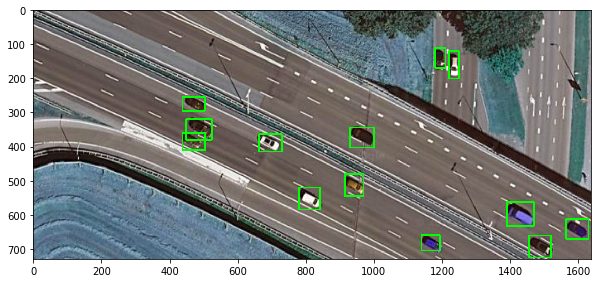

In [429]:
imgs = show_labelled_image(img, labels)

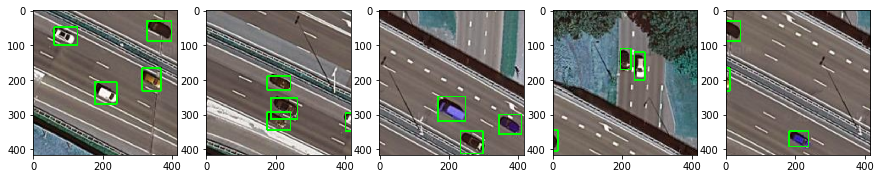

In [430]:
show_sliced_images(slices, imgs)